In [11]:
import sys
print(sys.executable)


c:\Users\smanasi\AppData\Local\miniconda3\envs\mammal\envs\mammal310\python.exe


In [12]:
import numpy as np
import pandas as pd

df = pd.read_csv("../data/sim_dataTL/sim_magnav_denoised.csv")
print(df.columns)
print("rows:", len(df))
print("num lines:", df["line"].nunique() if "line" in df else df["line_id"].nunique())
df.head()


Index(['time_s', 'lat', 'lon', 'alt_m', 'mag_scalar_nT',
       'mag_anomaly_injected_nT', 'mag_residual_nT', 'heading_deg',
       'turn_score_deg', 'is_turn', 'LINE', 'east_m', 'north_m', 'line',
       'LINE_TYPE', 'yaw_rad', 'pitch_rad', 'roll_rad', 'yaw_deg', 'pitch_deg',
       'roll_deg', 'psi_deg', 'psi_rad', 'F_raw', 'F_headcorr', 'delta_F',
       'F_smooth_sg', 'F_smooth_med', 'F_smooth_lp'],
      dtype='object')
rows: 148016
num lines: 18


,time_s,lat,lon,alt_m,mag_scalar_nT,mag_anomaly_injected_nT,mag_residual_nT,heading_deg,turn_score_deg,is_turn,...,pitch_deg,roll_deg,psi_deg,psi_rad,F_raw,F_headcorr,delta_F,F_smooth_sg,F_smooth_med,F_smooth_lp
0,0.00,-27.116237,131.084472,100.0,55445.483869,-6.953404,35.695884,0.0,0.0,False,...,0.0,0.0,0.0,0.0,35.695884,27.892867,7.803018,1.004351,0.0,36.926694
1,0.01,-27.116235,131.084472,100.0,55382.321804,-6.683435,-27.465100,0.0,0.0,False,...,0.0,0.0,0.0,0.0,-27.465100,-35.268117,7.803018,1.311708,0.0,34.160102
2,0.02,-27.116233,131.084472,100.0,55415.597191,-6.412450,5.811368,0.0,0.0,False,...,0.0,0.0,0.0,0.0,5.811368,-1.991650,7.803018,1.618821,0.0,31.474021
3,0.03,-27.116232,131.084472,100.0,55378.849986,-6.140469,-30.934757,0.0,0.0,False,...,0.0,0.0,0.0,0.0,-30.934757,-38.737774,7.803018,1.925684,0.0,28.886707
4,0.04,-27.116230,131.084472,100.0,55332.821138,-5.867511,-76.962524,0.0,0.0,False,...,0.0,0.0,0.0,0.0,-76.962524,-84.765542,7.803018,2.232294,0.0,26.415056


In [13]:
F_col = "F_smooth_sg"   # change to your actual column name
df["F"] = df[F_col].astype(float)


In [14]:
survey_df = pd.DataFrame({
    "LAT": df["lat"].astype(float),
    "LONG": df["lon"].astype(float),
    "F": df["F"].astype(float),
    "LINE": df["LINE"].astype(int),
    "LINE_TYPE": df["LINE_TYPE"].astype(int),
})


In [ ]:
#computes crossover diff at intersections (no leveling)
def compute_xovers_only(survey_df, F_col="F"):
    df = survey_df.copy()
    fl_mask = df["LINE_TYPE"].astype(int) == 1
    tl_mask = df["LINE_TYPE"].astype(int) == 2

    fl_ids = np.sort(df.loc[fl_mask, "LINE"].astype(int).unique())
    tl_ids = np.sort(df.loc[tl_mask, "LINE"].astype(int).unique())

    FL, TL = {}, {}
    for lid in fl_ids:
        FL[lid] = _prepare_line_arrays(df.loc[fl_mask & (df["LINE"].astype(int)==lid)], F_col=F_col)
    for lid in tl_ids:
        TL[lid] = _prepare_line_arrays(df.loc[tl_mask & (df["LINE"].astype(int)==lid)], F_col=F_col)

    rows=[]
    for fl_id in fl_ids:
        e_fl, n_fl, F_fl, s_fl, u_fl, p0_fl = FL[fl_id]
        e_star = float(np.median(e_fl))
        for tl_id in tl_ids:
            e_tl, n_tl, F_tl, s_tl, u_tl, p0_tl = TL[tl_id]
            n_star = float(np.median(n_tl))
            pt=(e_star,n_star)

            Ffl_i, sfl_i = _interp_F_at_point(e_fl,n_fl,F_fl,s_fl,u_fl,p0_fl,pt)
            Ftl_i, stl_i = _interp_F_at_point(e_tl,n_tl,F_tl,s_tl,u_tl,p0_tl,pt)

            rows.append({
                "FL": fl_id, "TL": tl_id,
                "east_i": e_star, "north_i": n_star,
                "diff_fl_minus_tl": Ffl_i - Ftl_i,
                "s_fl_i": sfl_i
            })
    return pd.DataFrame(rows)


In [32]:
#preparing line arrays (east meters, north meters, F_smoothed, s distance traveled, u direction, starting point)
def _prepare_line_arrays(df_line: pd.DataFrame, F_col="F"):#only the rows for one line ID
    """
    Return arrays for a single line:
    e, n, F, s_along (meters), unit direction u, start point p0
    """
    # Sort in acquisition order (time is safest)
    if "time_s" in df_line.columns:
        df_line = df_line.sort_values("time_s") #sort by time jic 
        
    e = df_line["east_m"].to_numpy(dtype=float)
    n = df_line["north_m"].to_numpy(dtype=float)
    F = df_line[F_col].to_numpy(dtype=float)    #e,n position at each point

    # cumulative distance along line
    de = np.diff(e)
    dn = np.diff(n)
    ds = np.sqrt(de**2 + dn**2)
    s = np.concatenate([[0.0], np.cumsum(ds)])          #calculate the distance along line

    # direction from first to last (unit vector)
    p0 = np.array([e[0], n[0]], dtype=float)
    p1 = np.array([e[-1], n[-1]], dtype=float)
    v = p1 - p0
    vnorm = np.linalg.norm(v)
    if vnorm < 1e-9:
        u = np.array([1.0, 0.0])  # degenerate fallback
    else:
        u = v / vnorm   #compute the direction of line - unit vector, north going = [0,1], east gong = [1,0]

    return e, n, F, s, u, p0

In [ ]:
def _interp_F_at_point(e, n, F, s, u, p0, pt):
    """
    Interpolate F along the line at the projected along-track coordinate of pt.
    """
    pt = np.array(pt, dtype=float)
    s_star = float(np.dot(pt - p0, u))  # projection of the vector from start to intersection point onto line direction
    #assumes that 1) line is straight, 2) the dist along the line is well represented by the projection
    # Clamp within the sampled range
    s_star = np.clip(s_star, s[0], s[-1])   
    
    # 1D linear interpolation (experiment with this) along s
    return float(np.interp(s_star, s, F)), s_star

In [34]:
df.groupby(["LINE_TYPE","LINE"]).size()


LINE_TYPE  LINE
1          0       10001
           1       10001
           2       10001
           3       10001
           4       10001
           5       10001
           6       10001
           7       10001
           8       10001
           9       10001
           10      10001
           11      10001
           12      10001
2          13       5201
           14        800
           15       5201
           16        800
           17       6001
dtype: int64

In [35]:
df.groupby("LINE")[["east_m","north_m"]].agg(["min","max"])


east_m                     north_m             
               min           max           min          max
LINE                                                       
0    -6.937739e-10  2.508500e-10  0.000000e+00  1999.999901
1     1.000000e+02  1.000000e+02  4.859757e-10  1999.999901
2     2.000000e+02  2.000000e+02 -2.308347e-10  1999.999900
3     3.000000e+02  3.000000e+02  7.368260e-10  1999.999899
4     4.000000e+02  4.000000e+02 -1.868949e-10  1999.999897
5     5.000000e+02  5.000000e+02 -8.902160e-10  1999.999895
6     6.000000e+02  6.000000e+02 -1.722142e-10  1999.999892
7     7.000000e+02  7.000000e+02  3.855832e-10  1999.999889
8     8.000000e+02  8.000000e+02 -1.998775e-10  1999.999885
9     8.999999e+02  9.000000e+02 -8.210581e-10  1999.999881
10    9.999999e+02  1.000000e+03 -2.413129e-10  1999.999876
11    1.100000e+03  1.100000e+03 -1.108372e-09  1999.999871
12    1.200000e+03  1.200000e+03  2.118777e-10  1999.999865
13   -1.566747e-10  1.040000e+03  5.000000e+02   499.999998
14    1.040200e+03  1.200000e+03  5.000000e+02   499.999992
15   -6.705534e-10  1.040000e+03  1.000000e+03   999.999988
16    1.040200e+03  1.200000e+03  1.000000e+03   999.999974
17    2.864908e-11  1.200000e+03  1.500000e+03  1499.999958

In [36]:
#line 0 was wrongly classified as a tl even tho it's a fl
#use line ranges to classify each line: 
#   range_north >> range_east
#   range_east >> range_north
import numpy as np

# classify each LINE by geometry
stats = df.groupby("LINE")[["east_m","north_m"]].agg(["min","max"])
e_range = (stats[("east_m","max")] - stats[("east_m","min")]).astype(float)
n_range = (stats[("north_m","max")] - stats[("north_m","min")]).astype(float)

line_type = {}
for lid in stats.index:
    er = e_range.loc[lid]
    nr = n_range.loc[lid]
    if nr > 5*er:         # mostly vertical
        line_type[lid] = 1
    elif er > 5*nr:       # mostly horizontal
        line_type[lid] = 2
    else:
        line_type[lid] = 0  # turn/ferry/diagonal

df["LINE_TYPE"] = df["LINE"].map(line_type).astype(int)

print(df.groupby(["LINE_TYPE","LINE"]).size())


LINE_TYPE  LINE
1          0       10001
           1       10001
           2       10001
           3       10001
           4       10001
           5       10001
           6       10001
           7       10001
           8       10001
           9       10001
           10      10001
           11      10001
           12      10001
2          13       5201
           14        800
           15       5201
           16        800
           17       6001
dtype: int64


In [52]:
def rms(x: np.ndarray) -> float:
    """
    Root-mean-square:
      rms = sqrt(mean(x^2))
    It measures typical error magnitude, punishing large outliers more than mean(|x|).
    """
    x = np.asarray(x, dtype=float)
    return float(np.sqrt(np.mean(x**2)))

In [37]:
#two tls each for north 500 and 1000 want to merge
# only for TL rows
tl_mask = df["LINE_TYPE"] == 2

# north is basically constant per TL; round to nearest meter
df.loc[tl_mask, "TL_GROUP"] = df.loc[tl_mask, "north_m"].round(0).astype(int)

# for FL rows, keep TL_GROUP as NaN
print(df.loc[tl_mask].groupby(["TL_GROUP","LINE"]).size())


TL_GROUP  LINE
500.0     13      5201
          14       800
1000.0    15      5201
          16       800
1500.0    17      6001
dtype: int64


What your current linewise method assumes

errors are line-dependent

each flight line has:

- either a constant offset, or

- a linear drift along its length

- tie lines act as a reference

This models:

- striping

- line-to-line inconsistencies

- heading/platform differences

- along-track drift

KEY ASSUMPTION:
LINES set truly contains only the vertical/horizontal tie/flight lines (not turns).
remove turns from the data beforehand

-> maybe can filter by heading direction (and detect turn) -> and remove those segments.

-> or between identified line segments, if no of samples (for turning) known, remove that part
-> 

In [ ]:
def tie_level_linewise(
    survey_df: pd.DataFrame,
    F_col: str = "F",           # which column to level
    model: str = "drift",       # "offset" or "drift"
    robust: bool = True,        # median-based offset if model="offset"
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Line-based tie leveling:
    - Uses ENU geometry (east_m, north_m)
    - Uses per-line interpolation along distance (no RBF)
    - Fits correction per FL from crossover differences vs along-track s
    Takes in:
    1) survey_df: my df with all the rows
    2) F_col: which coloumn in the magnetic data were gonna use to level
    3) model: "offset" assume each FL has constant bias
                "drift": assume each FL has a linear drift vs distance along line
    4) robust: median vs mean (median is safer)
    How?
    1) splits FL and TLs
    2) computes the crossovers
    3) fit correction model per FL
    4) subtract correction from FL samples
    4) return leveled df + crossover table
    
    Returns:
      lvld_df: copy of survey_df with leveled F (FL corrected, TL unchanged)
      xovers:  dataframe of crossover stats (before leveling)
    """
    #validating coloumns
    required = ["LINE", "LINE_TYPE", "east_m", "north_m", F_col]
    missing = [c for c in required if c not in survey_df.columns]
    if missing:
        raise ValueError(f"survey_df missing required columns: {missing}")

    #copy df
    df = survey_df.copy()

    # Split FL/TL
    fl_mask = df["LINE_TYPE"].astype(int) == 1
    tl_mask = df["LINE_TYPE"].astype(int) == 2

    #find unique fl/tl ids and make an array of them eg. [1..13]
    fl_ids = np.sort(df.loc[fl_mask, "LINE"].astype(int).unique())
    tl_ids = np.sort(df.loc[tl_mask, "LINE"].astype(int).unique())

    # Precompute per-line arrays
    FL = {}
    TL = {}

    for lid in fl_ids:
        df_line = df.loc[fl_mask & (df["LINE"].astype(int) == lid)]
        FL[lid] = _prepare_line_arrays(df_line, F_col=F_col)

    for lid in tl_ids:
        df_line = df.loc[tl_mask & (df["LINE"].astype(int) == lid)]
        TL[lid] = _prepare_line_arrays(df_line, F_col=F_col)

    # Build crossover table
    rows = []
    for fl_id in fl_ids:
        e_fl, n_fl, F_fl, s_fl, u_fl, p0_fl = FL[fl_id]

        # For a straight FL, representative "east" is median
        e_star = float(np.median(e_fl))     #assumption: the flight line is exactly aligned to north-south, and is straight

        for tl_id in tl_ids: #assuming each FL cuts through each TL once
            e_tl, n_tl, F_tl, s_tl, u_tl, p0_tl = TL[tl_id]

            # For a straight TL, representative "north" is median
            n_star = float(np.median(n_tl))     #assumption that tl is strictly/mostly East-West so taking median is representative

            # intersection estimate
            pt = (e_star, n_star)

            Ffl_i, sfl_i = _interp_F_at_point(e_fl, n_fl, F_fl, s_fl, u_fl, p0_fl, pt)
            Ftl_i, stl_i = _interp_F_at_point(e_tl, n_tl, F_tl, s_tl, u_tl, p0_tl, pt)#tl and fl interpolated to intersection

            diff = Ffl_i - Ftl_i    #compute crossover difference

            rows.append({
                "FL": fl_id,
                "TL": tl_id,
                "east_i": e_star,
                "north_i": n_star,
                "F_fl_i": Ffl_i,
                "F_tl_i": Ftl_i,
                "diff_fl_minus_tl": diff,
                "s_fl_i": sfl_i,
            })

    xovers = pd.DataFrame(rows)
    
    # Fit correction per flight line
    df["F_leveled"] = df[F_col].astype(float).to_numpy()

    for fl_id in fl_ids:    #for each fl - solve for one correction model
        fl_rows = xovers[xovers["FL"] == fl_id]
        y = fl_rows["diff_fl_minus_tl"].to_numpy(dtype=float)   #how wrong this fl is at each tl crossing
        s_i = fl_rows["s_fl_i"].to_numpy(dtype=float)       #where along the FL was this error observed

        # Get this FL samples
        fl_samp_mask = fl_mask & (df["LINE"].astype(int) == fl_id)
        df_fl = df.loc[fl_samp_mask]
        e = df_fl["east_m"].to_numpy(dtype=float)
        n = df_fl["north_m"].to_numpy(dtype=float)
        F = df_fl[F_col].to_numpy(dtype=float)

        # distance along this FL (same as in _prepare_line_arrays)
        de = np.diff(e); dn = np.diff(n)
        s_line = np.concatenate([[0.0], np.cumsum(np.sqrt(de**2 + dn**2))])

        if model.lower() == "offset":
            # constant offset per FL
            b = np.median(y) if robust else np.mean(y)  #just take median/mean of the errors to get constant offset
            corr = np.full_like(F, b, dtype=float)

        elif model.lower() == "drift":
            # linear drift per FL: y ≈ a*s + b
            A = np.column_stack([s_i, np.ones_like(s_i)])
            a, b = np.linalg.lstsq(A, y, rcond=None)[0] #linear least sqaures to fit the error - but if only 3 tie lines is that bad
            corr = a * s_line + b

        else:
            raise ValueError("model must be 'offset' or 'drift'")

        # Subtract correction from this FL
        df.loc[fl_samp_mask, "F_leveled"] = F - corr

    return df, xovers

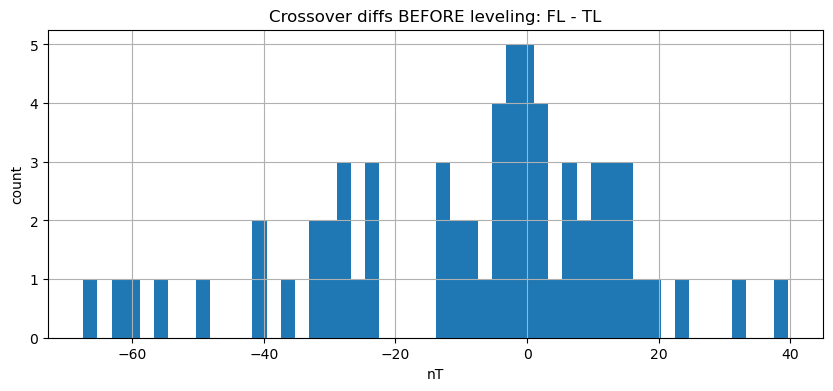

Crossover RMS (before): 23.989328439573068
Crossover median (before): -2.6756921228448647


,F_leveled
0,106.836976
1,104.064933
2,101.373401
3,98.780636
4,96.303534


In [39]:
survey_df = df.copy()
F_col = "F_smooth_lp"     # or "F_headcorr" or whatever you trust most

lvld_df, xovers = tie_level_linewise(
    survey_df=survey_df,
    F_col=F_col,
    model="drift",        # start with drift (as+b)
    robust=True
)

lvld_df[["F_leveled"]].head()


In [43]:
print(x_before.columns)
print(x_before.head())


Index(['FL', 'TL', 'east_i', 'north_i', 'diff_fl_minus_tl', 's_fl_i'], dtype='object')
   FL  TL        east_i      north_i  diff_fl_minus_tl       s_fl_i
0   0  13 -2.162892e-10   499.999997        -40.162586   499.999997
1   0  14 -2.162892e-10   499.999991        -67.391017   499.999991
2   0  15 -2.162892e-10   999.999984        -39.907585   999.999984
3   0  16 -2.162892e-10   999.999972        -55.430143   999.999972
4   0  17 -2.162892e-10  1499.999951        -24.016228  1499.999951


In [51]:
x_before = compute_xovers_only(df, F_col="F_smooth_lp")
lvld_df, _ = tie_level_linewise(df, F_col="F_smooth_lp", model="drift")
x_after  = compute_xovers_only(lvld_df, F_col="F_leveled")

d0 = x_before["diff_fl_minus_tl"].to_numpy(dtype=float)
d1 = x_after["diff_fl_minus_tl"].to_numpy(dtype=float)

rms0 = np.sqrt(np.mean(d0**2))
rms1 = np.sqrt(np.mean(d1**2))

print("RMS before:", rms0)
print("RMS after :", rms1)

RMS before: 23.989328439573068
RMS after : 14.835916829563024


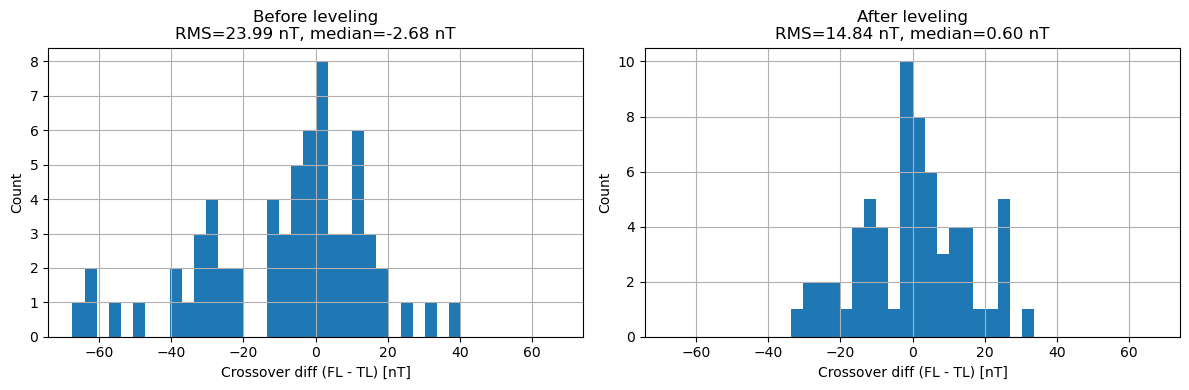

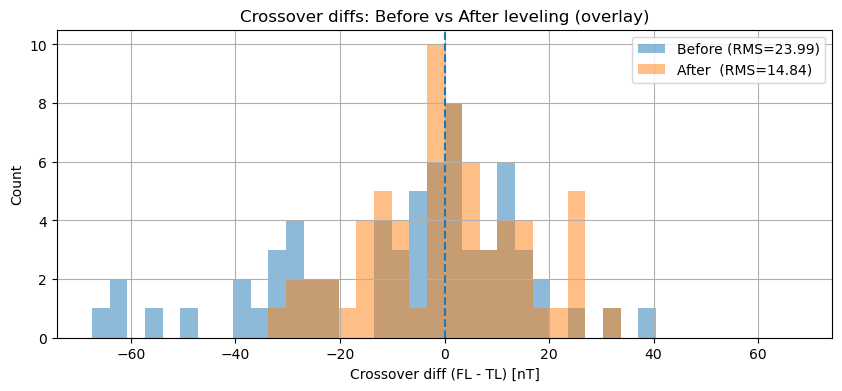

In [ ]:
# ----------------------------
# 1) SIDE-BY-SIDE HISTOGRAMS
# ----------------------------
bins = 40
lim = np.nanmax(np.abs(np.concatenate([d0, d1])))
lims = (-lim, lim)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(d0, bins=bins, range=lims)
plt.title(f"Before leveling\nRMS={rms0:.2f} nT, median={np.median(d0):.2f} nT")
plt.xlabel("Crossover diff (FL - TL) [nT]")
plt.ylabel("Count")
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(d1, bins=bins, range=lims)
plt.title(f"After leveling\nRMS={rms1:.2f} nT, median={np.median(d1):.2f} nT")
plt.xlabel("Crossover diff (FL - TL) [nT]")
plt.ylabel("Count")
plt.grid(True)

plt.tight_layout()
plt.show()

# ----------------------------
# 2) OVERLAY HISTOGRAM (same bins)
# ----------------------------
plt.figure(figsize=(10,4))
plt.hist(d0, bins=bins, range=lims, alpha=0.5, label=f"Before (RMS={rms0:.2f})")
plt.hist(d1, bins=bins, range=lims, alpha=0.5, label=f"After  (RMS={rms1:.2f})")
plt.axvline(0, linestyle="--")
plt.title("Crossover diffs: Before vs After leveling (overlay)")
plt.xlabel("Crossover diff (FL - TL) [nT]")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.show()
#xyz yayay

In [46]:
x_before = compute_xovers_only(df, F_col="F_smooth_lp")
lvld_df, _ = tie_level_linewise(df, F_col="F_smooth_lp", model="offset")
x_after  = compute_xovers_only(lvld_df, F_col="F_leveled")

print("RMS before:", np.sqrt(np.mean(x_before["diff_fl_minus_tl"]**2)))
print("RMS after :", np.sqrt(np.mean(x_after["diff_fl_minus_tl"]**2)))


RMS before: 23.989328439573068
RMS after : 19.254776055715425


How about instead of linewise fitting we do plane-fitting instead?
What plane-fitting assumes

When you fit a plane:
ΔF(x,y)≈ax+by+c

you are assuming:

- the error is smooth

- the error varies slowly over space

- the error is global, not per-line

This typically models:

- diurnal residuals

- regional drift

- long-wavelength bias

- altitude-dependent or time-dependent effects

In [53]:
def tie_level_plane(
    survey_df: pd.DataFrame,
    F_col: str,
    apply_to: str = "FL",      # "FL" or "ALL"
    robust: bool = False,      # robust plane fit via iteratively reweighted LS
    iters: int = 5,
) -> tuple[pd.DataFrame, pd.DataFrame, dict]:
    """
    Tie leveling by fitting a plane to crossover differences:

      diff = F_FL(x_i,y_i) - F_TL(x_i,y_i)
      diff(x,y) ≈ a*x + b*y + c

    Then correct:
      F_leveled = F - (a*x + b*y + c)

    Params
    ------
    survey_df : dataframe with LINE, LINE_TYPE, east_m, north_m, F_col
    F_col     : magnetic data column to level
    apply_to  : "FL" -> apply correction only to flight lines
               "ALL" -> apply to all points (usually not needed)
    robust    : if True, uses a simple IRLS loop to reduce outlier influence
    iters     : IRLS iterations (only used if robust=True)

    Returns
    -------
    lvld_df : copy of survey_df with new column 'F_leveled_plane'
    xovers  : crossover table computed from F_col (before leveling)
    fitinfo : dict with plane coefficients and fit diagnostics
    """
    df = survey_df.copy()

    # 1) compute crossovers using the chosen magnetic column
    xovers = compute_xovers_only(df, F_col=F_col)

    # 2) build plane design matrix A and target y
    # y = a*east + b*north + c
    x = xovers["east_i"].to_numpy(dtype=float)
    y = xovers["north_i"].to_numpy(dtype=float)
    d = xovers["diff_fl_minus_tl"].to_numpy(dtype=float)

    A = np.column_stack([x, y, np.ones_like(x)])  # [east, north, 1] so can get a, b, and c

    # 3) solve least squares (or robust IRLS)
    if not robust:
        coeffs, *_ = np.linalg.lstsq(A, d, rcond=None)  # coeffs = [a, b, c]
        w = np.ones_like(d)
    else:
        # Simple robust loop: reweight by Huber-ish rule on residuals
        coeffs = np.zeros(3, dtype=float)
        w = np.ones_like(d, dtype=float)

        for _ in range(iters):
            W = np.diag(w)
            coeffs, *_ = np.linalg.lstsq(W @ A, W @ d, rcond=None)

            resid = d - (A @ coeffs)

            # robust scale estimate using MAD
            mad = np.median(np.abs(resid - np.median(resid))) + 1e-9
            sigma = 1.4826 * mad  # approx std if normal

            # Huber weights
            k = 1.345 * sigma
            w = np.where(np.abs(resid) <= k, 1.0, k / (np.abs(resid) + 1e-12))

    a, b, c = coeffs

    # 4) apply correction to samples
    corr = a * df["east_m"].to_numpy(dtype=float) + b * df["north_m"].to_numpy(dtype=float) + c

    df["F_leveled_plane"] = df[F_col].to_numpy(dtype=float)  # start as original
    if apply_to.upper() == "FL":
        fl_mask = df["LINE_TYPE"].astype(int) == 1
        df.loc[fl_mask, "F_leveled_plane"] = df.loc[fl_mask, F_col].to_numpy(dtype=float) - corr[fl_mask.to_numpy()]
    elif apply_to.upper() == "ALL":
        df["F_leveled_plane"] = df[F_col].to_numpy(dtype=float) - corr
    else:
        raise ValueError("apply_to must be 'FL' or 'ALL'")

    # 5) diagnostics (how well does plane explain crossover diffs?)
    d_pred = A @ coeffs
    resid = d - d_pred
    fitinfo = {
        "a": float(a),
        "b": float(b),
        "c": float(c),
        "rms_crossovers_before": rms(d),
        "rms_plane_residual": rms(resid),
        "median_crossovers_before": float(np.median(d)),
        "median_plane_residual": float(np.median(resid)),
        "robust": bool(robust),
        "iters": int(iters),
    }

    return df, xovers, fitinfo


Crossover RMS (before): 23.989328439573068
Crossover median (before): -2.6756921228448647
Plane fit info: {'a': 0.032616769781914474, 'b': 0.014619904986751022, 'c': -40.84261135098113, 'rms_crossovers_before': 23.989328439573068, 'rms_plane_residual': 18.187282258491795, 'median_crossovers_before': -2.6756921228448647, 'median_plane_residual': -2.6745880244528166, 'robust': False, 'iters': 5}
Crossover RMS (after): 18.18728222349893
Crossover median (after): -2.6745880244528024


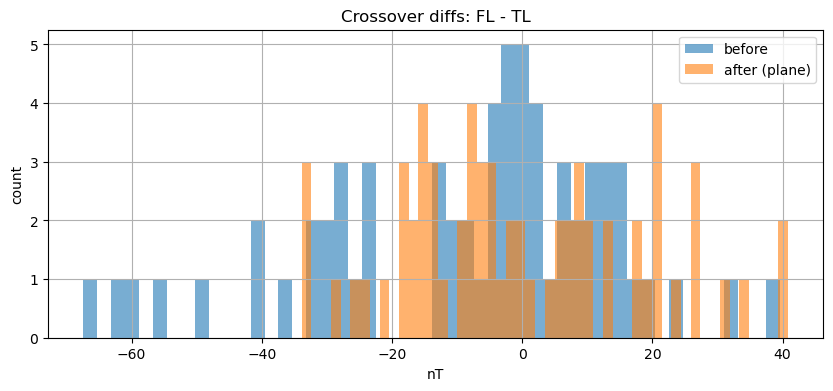

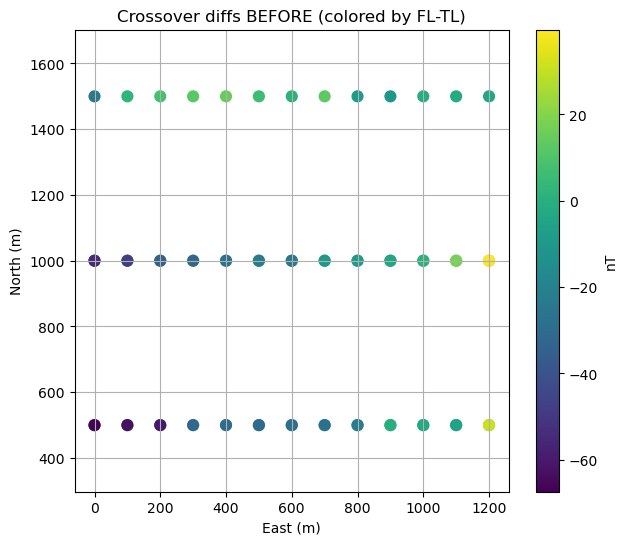

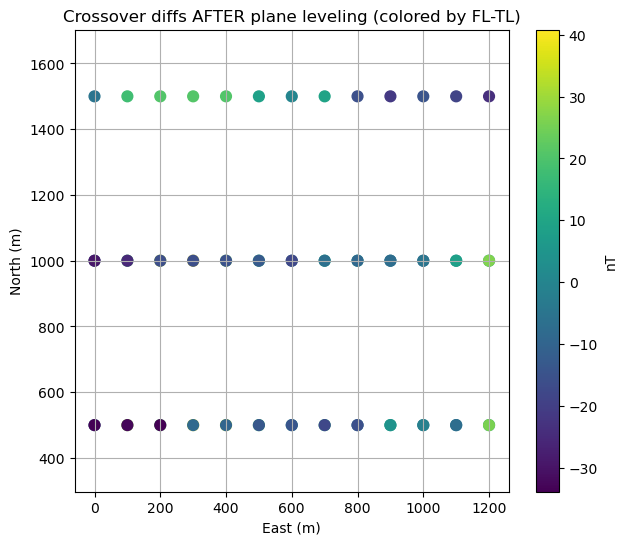

In [54]:
F_in = "F_smooth_lp"

# BEFORE
x_before = compute_xovers_only(df, F_col=F_in)
print("Crossover RMS (before):", rms(x_before["diff_fl_minus_tl"].values))
print("Crossover median (before):", np.median(x_before["diff_fl_minus_tl"].values))

# PLANE LEVEL
lvld_plane, x0, info = tie_level_plane(df, F_col=F_in, apply_to="FL", robust=False)
print("Plane fit info:", info)

# AFTER (recompute xovers using leveled column)
x_after = compute_xovers_only(lvld_plane, F_col="F_leveled_plane")
print("Crossover RMS (after):", rms(x_after["diff_fl_minus_tl"].values))
print("Crossover median (after):", np.median(x_after["diff_fl_minus_tl"].values))

# --- Plot 1: hist before/after
plt.figure(figsize=(10,4))
plt.hist(x_before["diff_fl_minus_tl"], bins=50, alpha=0.6, label="before")
plt.hist(x_after["diff_fl_minus_tl"], bins=50, alpha=0.6, label="after (plane)")
plt.title("Crossover diffs: FL - TL")
plt.xlabel("nT")
plt.ylabel("count")
plt.grid(True)
plt.legend()
plt.show()

# --- Plot 2: spatial scatter of crossover diffs before/after
plt.figure(figsize=(7,6))
plt.scatter(x_before["east_i"], x_before["north_i"], c=x_before["diff_fl_minus_tl"], s=60)
plt.title("Crossover diffs BEFORE (colored by FL-TL)")
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.axis("equal")
plt.grid(True)
plt.colorbar(label="nT")
plt.show()

plt.figure(figsize=(7,6))
plt.scatter(x_after["east_i"], x_after["north_i"], c=x_after["diff_fl_minus_tl"], s=60)
plt.title("Crossover diffs AFTER plane leveling (colored by FL-TL)")
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.axis("equal")
plt.grid(True)
plt.colorbar(label="nT")
plt.show()


Linewise drift RMS before: 23.989328439573068
Linewise drift RMS after : 14.835916829563024


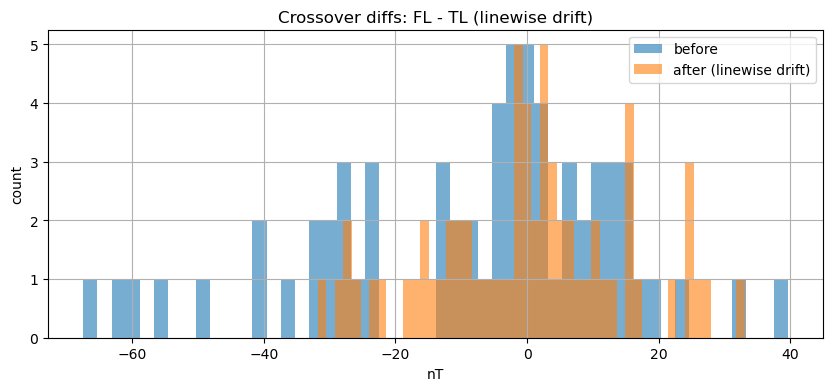

In [55]:
# LINEWISE DRIFT LEVEL
lvld_line, x_line_before = tie_level_linewise(df, F_col=F_in, model="drift", robust=True)
x_line_after = compute_xovers_only(lvld_line, F_col="F_leveled")

print("Linewise drift RMS before:", rms(x_line_before["diff_fl_minus_tl"].values))
print("Linewise drift RMS after :", rms(x_line_after["diff_fl_minus_tl"].values))

plt.figure(figsize=(10,4))
plt.hist(x_line_before["diff_fl_minus_tl"], bins=50, alpha=0.6, label="before")
plt.hist(x_line_after["diff_fl_minus_tl"], bins=50, alpha=0.6, label="after (linewise drift)")
plt.title("Crossover diffs: FL - TL (linewise drift)")
plt.xlabel("nT")
plt.ylabel("count")
plt.grid(True)
plt.legend()
plt.show()


What could be happening? Linewise works better than plane-fitting and correction

Linewise:
“Each flight line can have its own bias / slow drift along-track.”

That matches very common real survey problems:

- sensor drift with time

- line-to-line DC offsets

- line-to-line slow trend due to temperature, power, etc.

- small heading-dependent bias that becomes “a different offset” for different heading groups (in lawnmower surveys headings are mostly 0/180, so it often looks like per-line bias)

✅ This method is flexible: each line gets its own correction.

Planewise good if:

“The mismatch is basically a smooth regional tilt (or gentle surface) across the whole survey area.”

This is good when the error is “map-like”, for example:

- a broad regional gradient error (e.g., wrong IGRF removal / reference)

- very low-frequency spatial bias

- a gentle “warp” that is consistent across all lines

❌ But if the true error is “each line has its own personality”, a single plane can’t capture that.

FOR SIM DATA:
For each FL, you have exactly 3 crossover constraints.
->
A linear drift model per FL needs 2 parameters (a, b).
With 3 points, it can fit pretty well (often almost exactly if noise is small-ish).
->
A global plane uses all crossovers together, but it only has 3 parameters total for the whole survey.

So: plane = underfitting, linewise drift = closer fit.

Missing column: F_leveled
Missing column: F_leveled_plane


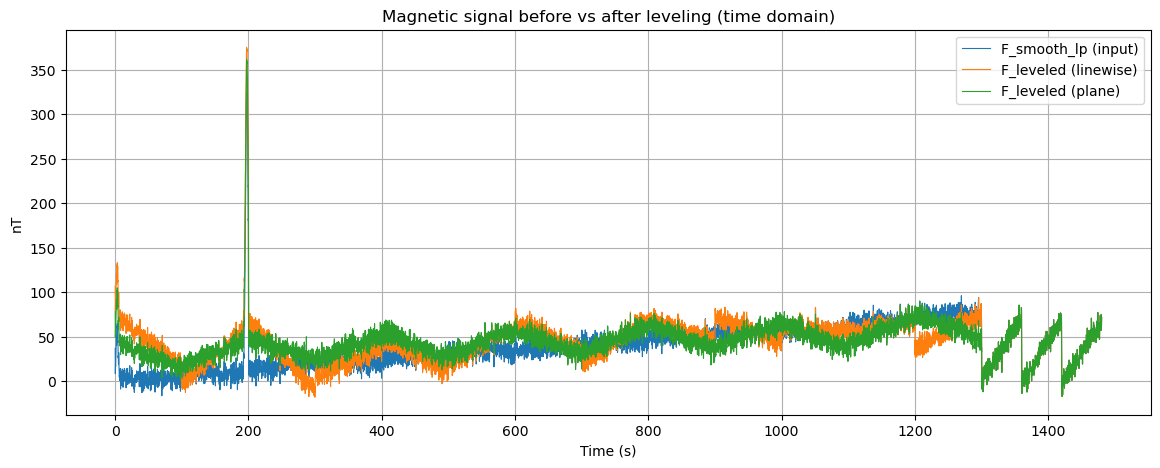

In [60]:
#DO SOME PLOTTING TO VISUALIZE HOW MUCH F IS SHAVED OFF

# --- choose what your "input" signal is (pre-leveling) ---
F_in_col = "F_smooth_lp"   # or F_smooth_sg / F_smooth_med / F_headcorr etc.

# --- define where the leveled outputs live ---
# linewise output: from tie_level_linewise() you made -> column is "F_leveled"
F_line_col  = "F_leveled"

# plane output: set this to whatever column name your plane leveling wrote
# (common names: "F_plane", "F_leveled_plane", "F_plane_leveled")
F_plane_col = "F_leveled_plane"   # <-- CHANGE if needed

# sanity checks
for c in [F_in_col, F_line_col, F_plane_col, "time_s", "east_m", "north_m"]:
    if c not in df.columns:
        print("Missing column:", c)

# pull arrays
t  = df["time_s"].to_numpy(float)
Fin = df[F_in_col].to_numpy(float)
Flw = lvld_line[F_line_col].to_numpy(float)
Fpl = lvld_plane[F_plane_col].to_numpy(float)

# differences = "what got shaved off"
d_lw = Fin - Flw
d_pl = Fin - Fpl

# ---------------------------
# 1) TIME SERIES OVERLAY
# ---------------------------
plt.figure(figsize=(14,5))
plt.plot(t, Fin, linewidth=0.8, label=f"{F_in_col} (input)")
plt.plot(t, Flw, linewidth=0.8, label="F_leveled (linewise)")
plt.plot(t, Fpl, linewidth=0.8, label="F_leveled (plane)")
plt.title("Magnetic signal before vs after leveling (time domain)")
plt.xlabel("Time (s)")
plt.ylabel("nT")
plt.grid(True)
plt.legend()
plt.show()

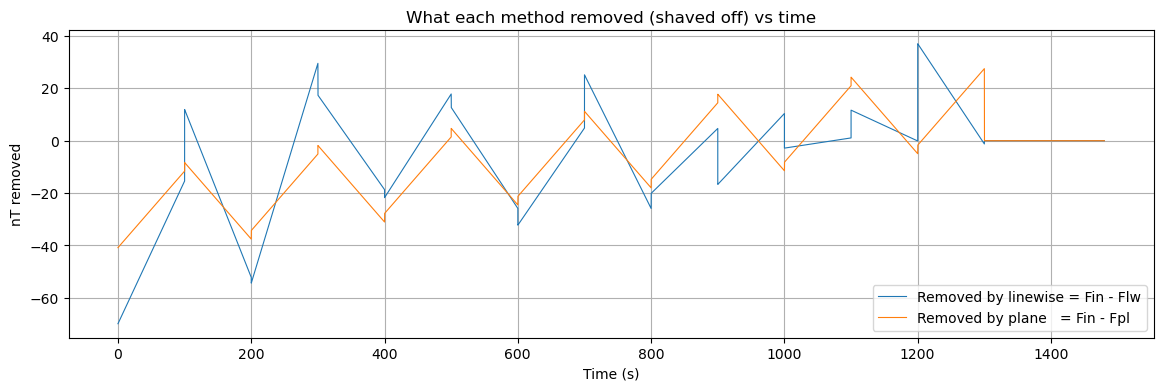

In [61]:
# ---------------------------
# 2) SHAVED-OFF AMOUNT (TIME)
# ---------------------------
plt.figure(figsize=(14,4))
plt.plot(t, d_lw, linewidth=0.8, label="Removed by linewise = Fin - Flw")
plt.plot(t, d_pl, linewidth=0.8, label="Removed by plane   = Fin - Fpl")
plt.title("What each method removed (shaved off) vs time")
plt.xlabel("Time (s)")
plt.ylabel("nT removed")
plt.grid(True)
plt.legend()
plt.show()

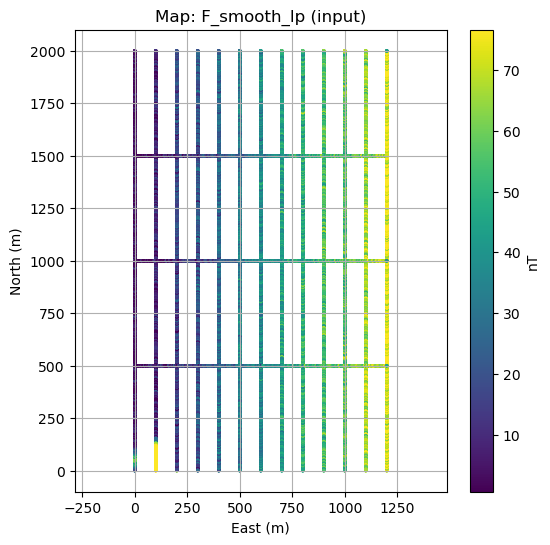

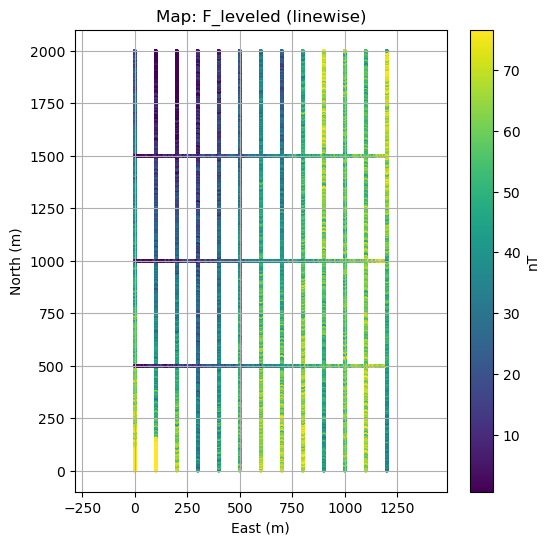

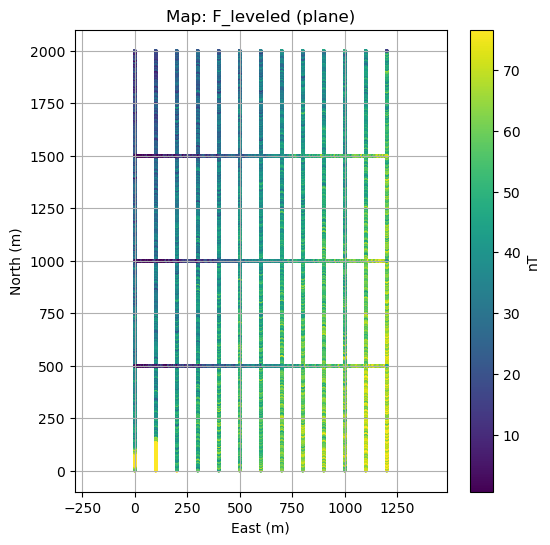

In [62]:
# ---------------------------
# 4) MAP VIEW (same color limits)
# ---------------------------
E = df["east_m"].to_numpy(float)
N = df["north_m"].to_numpy(float)

# robust color limits so outliers don't ruin visibility
all_vals = np.concatenate([Fin, Flw, Fpl])
vmin, vmax = np.percentile(all_vals, [2, 98])

plt.figure(figsize=(6,6))
plt.scatter(E, N, c=Fin, s=2, vmin=vmin, vmax=vmax)
plt.title(f"Map: {F_in_col} (input)")
plt.xlabel("East (m)"); plt.ylabel("North (m)")
plt.axis("equal"); plt.grid(True)
plt.colorbar(label="nT")
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(E, N, c=Flw, s=2, vmin=vmin, vmax=vmax)
plt.title("Map: F_leveled (linewise)")
plt.xlabel("East (m)"); plt.ylabel("North (m)")
plt.axis("equal"); plt.grid(True)
plt.colorbar(label="nT")
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(E, N, c=Fpl, s=2, vmin=vmin, vmax=vmax)
plt.title("Map: F_leveled (plane)")
plt.xlabel("East (m)"); plt.ylabel("North (m)")
plt.axis("equal"); plt.grid(True)
plt.colorbar(label="nT")
plt.show()

In [69]:
# --- Build master dataframe to export ---
export_df = df.copy()

# Add linewise leveled result
export_df["F_leveled_line"] = lvld_line["F_leveled"].to_numpy()

# Add plane leveled result
export_df["F_leveled_plane"] = lvld_plane["F_leveled_plane"].to_numpy()

# (Optional) sanity checks
assert len(export_df) == len(df) == len(lvld_line) == len(lvld_plane)

out_path = "../data/sim_dataTL/sim_magnav_leveled_master.csv"
export_df.to_csv(out_path, index=False)
print("Saved:", out_path)
print("Columns:", export_df.columns.tolist())


Saved: ../data/sim_dataTL/sim_magnav_leveled_master.csv
Columns: ['time_s', 'lat', 'lon', 'alt_m', 'mag_scalar_nT', 'mag_anomaly_injected_nT', 'mag_residual_nT', 'heading_deg', 'turn_score_deg', 'is_turn', 'LINE', 'east_m', 'north_m', 'line', 'LINE_TYPE', 'yaw_rad', 'pitch_rad', 'roll_rad', 'yaw_deg', 'pitch_deg', 'roll_deg', 'psi_deg', 'psi_rad', 'F_raw', 'F_headcorr', 'delta_F', 'F_smooth_sg', 'F_smooth_med', 'F_smooth_lp', 'F', 'TL_GROUP', 'F_leveled_line', 'F_leveled_plane']


In [63]:
import numpy as np
import pandas as pd
from pyproj import CRS, Transformer
import rasterio
from rasterio.transform import from_origin

def df_to_geotiff_utm(
    df: pd.DataFrame,
    value_col: str,
    out_tif: str,
    pixel_size_m: float = 20.0,
    agg: str = "mean",  # "mean" or "median"
):
    # ---- 1) get lon/lat/value ----
    lon = df["lon"].to_numpy(float)
    lat = df["lat"].to_numpy(float)
    val = df[value_col].to_numpy(float)

    # drop NaNs
    m = np.isfinite(lon) & np.isfinite(lat) & np.isfinite(val)
    lon, lat, val = lon[m], lat[m], val[m]

    # ---- 2) choose UTM zone from data center ----
    lon0 = float(np.median(lon))
    lat0 = float(np.median(lat))
    zone = int((lon0 + 180) // 6) + 1
    is_south = lat0 < 0
    utm_crs = CRS.from_dict({"proj": "utm", "zone": zone, "south": is_south})
    wgs84 = CRS.from_epsg(4326)

    tfm = Transformer.from_crs(wgs84, utm_crs, always_xy=True)
    x, y = tfm.transform(lon, lat)  # meters

    # ---- 3) build grid ----
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    nx = int(np.ceil((xmax - xmin) / pixel_size_m)) + 1
    ny = int(np.ceil((ymax - ymin) / pixel_size_m)) + 1

    # row/col for each point (note: y decreases as row increases)
    col = ((x - xmin) / pixel_size_m).astype(int)
    row = ((ymax - y) / pixel_size_m).astype(int)

    grid = np.full((ny, nx), np.nan, dtype=np.float32)

    # ---- 4) bin-aggregate (mean/median) ----
    tmp = pd.DataFrame({"row": row, "col": col, "val": val})
    if agg == "median":
        g = tmp.groupby(["row", "col"])["val"].median()
    else:
        g = tmp.groupby(["row", "col"])["val"].mean()

    rr = g.index.get_level_values(0).to_numpy()
    cc = g.index.get_level_values(1).to_numpy()
    grid[rr, cc] = g.to_numpy(np.float32)

    # ---- 5) write GeoTIFF ----
    transform = from_origin(xmin, ymax, pixel_size_m, pixel_size_m)

    with rasterio.open(
        out_tif,
        "w",
        driver="GTiff",
        height=grid.shape[0],
        width=grid.shape[1],
        count=1,
        dtype="float32",
        crs=utm_crs,
        transform=transform,
        nodata=np.nan,
        compress="deflate",
    ) as dst:
        dst.write(grid, 1)

    print("Saved:", out_tif)
    print("CRS:", utm_crs)
    print("Grid shape:", grid.shape, "pixel_size_m:", pixel_size_m)

# Example:
df_to_geotiff_utm(df=lvld_line, value_col="F_leveled", out_tif="F_leveled_linewise.tif", pixel_size_m=20, agg="mean")
df_to_geotiff_utm(df=lvld_plane, value_col="F_leveled_plane", out_tif="F_leveled_plane.tif", pixel_size_m=20, agg="mean")


Saved: F_leveled_linewise.tif
CRS: +proj=utm +zone=52 +south +type=crs
Grid shape: (102, 63) pixel_size_m: 20
Saved: F_leveled_plane.tif
CRS: +proj=utm +zone=52 +south +type=crs
Grid shape: (102, 63) pixel_size_m: 20


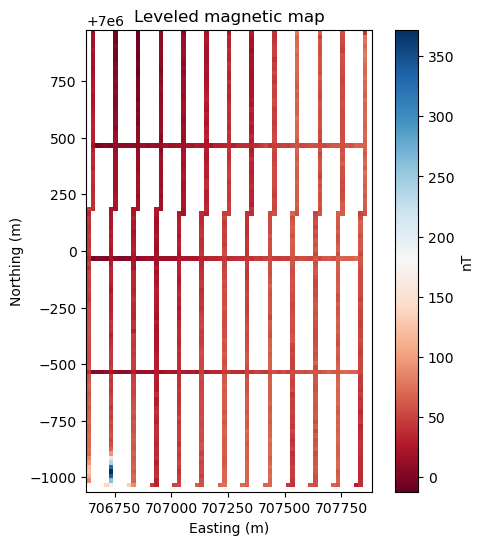

In [64]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open("F_leveled_linewise.tif") as ds:
    img = ds.read(1)
    extent = (
        ds.bounds.left,
        ds.bounds.right,
        ds.bounds.bottom,
        ds.bounds.top,
    )

plt.figure(figsize=(6,6))
plt.imshow(img, extent=extent, origin="upper", cmap="RdBu")
plt.colorbar(label="nT")
plt.title("Leveled magnetic map")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()


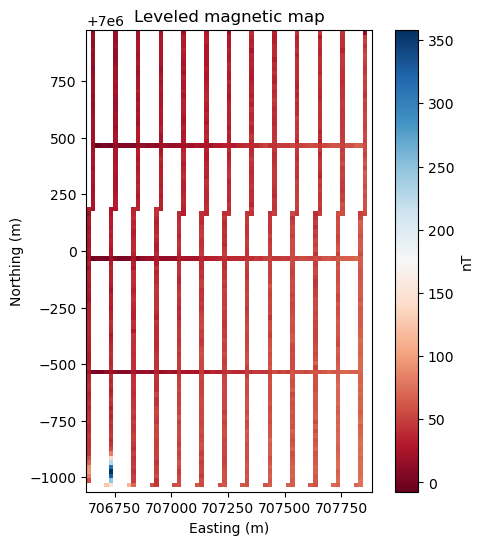

In [68]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open("F_leveled_plane.tif") as ds:
    img = ds.read(1)
    extent = (
        ds.bounds.left,
        ds.bounds.right,
        ds.bounds.bottom,
        ds.bounds.top,
    )

plt.figure(figsize=(6,6))
plt.imshow(img, extent=extent, origin="upper", cmap="RdBu")
plt.colorbar(label="nT")
plt.title("Leveled magnetic map")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()


In [67]:
with rasterio.open("F_leveled_linewise.tif") as ds:
    print(ds.crs)
    print(ds.transform)
    print(ds.width, ds.height)


EPSG:32752
| 20.00, 0.00, 706625.05|
| 0.00,-20.00, 7000976.66|
| 0.00, 0.00, 1.00|
63 102
